In [1]:
from time import time
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_lfw_pairs

import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
lfw_dataset_train = fetch_lfw_pairs(subset='train', resize=0.4, color=True)
lfw_dataset_test = fetch_lfw_pairs(subset='test',resize=0.4, color=True)

In [3]:
X_train = lfw_dataset_train.data
y_train = lfw_dataset_train.target

X_test = lfw_dataset_test.data
y_test = lfw_dataset_test.target

In [9]:
lfw_dataset_train.target

array([1, 1, 1, ..., 0, 0, 0])

In [6]:
lfw_dataset_train.pairs.shape

(2200, 2, 50, 37, 3)

In [17]:
50*37*3*2

11100

In [13]:
lfw_dataset_test.pairs.shape

(1000, 2, 50, 37, 3)

TypeError: Invalid shape (11100,) for image data

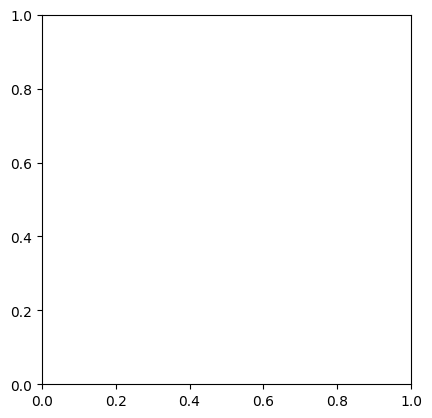

In [18]:
plt.imshow(lfw_dataset_train.data[0])

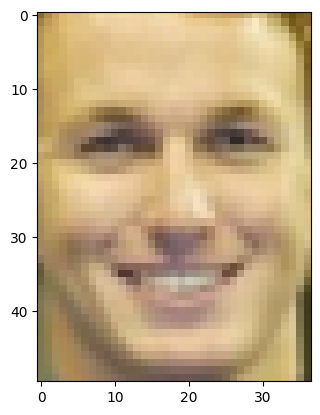

In [10]:
plt.imshow(lfw_dataset_train.pairs[1][0])

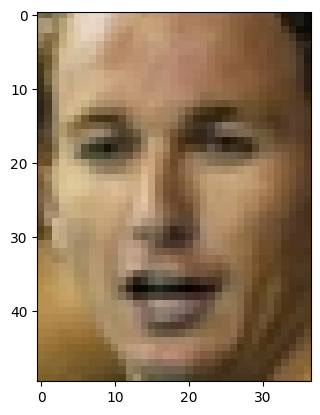

In [11]:
plt.imshow(lfw_dataset_train.pairs[1][1])

In [19]:
def prepare_dataset(lfw_dataset):
    cnn_data = []
    cnn_data_1 = []
    cnn_data_2 = []
    for images_paris in lfw_dataset['pairs']:
        image1 = images_paris[0]
        image2 = images_paris[1]
        # Stack the two images along the channel axis to create a single image 
        # with dimensions (32, 32, 6)
        combined_image = np.concatenate((image1, image2), axis=0)
        # combined_image = combined_image[:, :, :3]
        cnn_data_1.append(image1)
        cnn_data_2.append(image2)
        cnn_data.append(combined_image)
    cnn_data  = np.stack(cnn_data, axis=0)
    cnn_data_1  = np.stack(cnn_data_1, axis=0)
    cnn_data_2  = np.stack(cnn_data_2, axis=0)
    
    return cnn_data, cnn_data_1, cnn_data_2


cnn_train_data, cnn_train_data_1, cnn_train_data_2 = prepare_dataset(lfw_dataset_train)
cnn_test_data, cnn_test_data_1, cnn_test_data_2 = prepare_dataset(lfw_dataset_test)

In [20]:
# %load ../../python_script/feature_extraction
import cv2
import numpy as np
from skimage import data
from skimage.feature import hog
from skimage import data, exposure
from skimage.color import label2rgb
from skimage.transform import rotate
from skimage.feature import local_binary_pattern


def histogram_oriented_gradients(image):
    # Example usage on a single image
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

    # Visualize the HOG image
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image_rescaled
  
def scale_invariant_feature_transform(image):
    
    # Convert the image depth to CV_8U
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    #reading image
    gray1 = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)
    
    #keypoints
    #keypoints``
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(gray1, None)

    img_1 = cv2.drawKeypoints(gray1,keypoints_1,image)
    return img_1
    
def local_binary_patterns(image):
    
    # settings for LBP
    radius = 3
    n_points = 8 * radius
    
    # Convert the image depth to CV_8U
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Convert the array to grayscale and reshape it to (height, width)
    gray1 = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray1, n_points, radius, method = "uniform")

    return lbp

### 1. Preparing the scale_invariant_feature_transform data

In [21]:
image_rescaled = {}
def sift_data(data):
    flattend_arr = []
    sift_image = []
    for image in data:
        arr_2d = scale_invariant_feature_transform(image)
        sift_image.append(arr_2d)
        flattend_arr.append(arr_2d.flatten())
        
    return np.array(flattend_arr), np.array(sift_image)


image_rescaled["sift_data_1"], image_rescaled["sift_image_1"] = sift_data(cnn_train_data_1)
image_rescaled["sift_data_2"], image_rescaled["sift_image_2"] = sift_data(cnn_train_data_2)
image_rescaled["sift_data_test_1"],image_rescaled["sift_image_test_1"] = sift_data(cnn_test_data_1)
image_rescaled["sift_data_test_2"],image_rescaled["sift_image_test_2"] = sift_data(cnn_test_data_2)

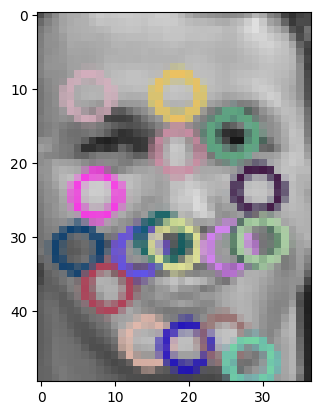

In [22]:
plt.imshow(image_rescaled["sift_image_1"][1])

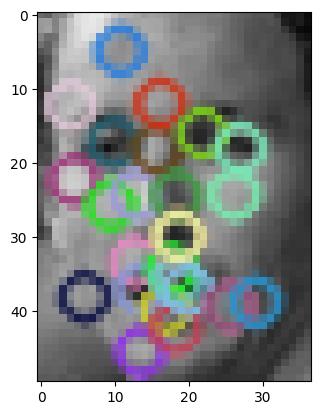

In [23]:
plt.imshow(image_rescaled["sift_image_2"][1])

### 2. Preparing the histogram_oriented_gradients of sift_data

In [24]:
import cv2

In [25]:
def hog_data(data):
    flattend_arr = []
    hog_image = []
    for image in data:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        arr_2d = histogram_oriented_gradients(gray_image)
        hog_image.append(arr_2d)
        flattend_arr.append(arr_2d.flatten())
        
    return np.array(flattend_arr), np.array(hog_image)

image_rescaled["hog_data_1"], image_rescaled["hog_image_1"] = hog_data(cnn_train_data_1)
image_rescaled["hog_data_2"], image_rescaled["hog_image_2"] = hog_data(cnn_train_data_2)
image_rescaled["hog_data_test_1"], image_rescaled["hog_image_test_1"] = hog_data(cnn_test_data_1)
image_rescaled["hog_data_test_2"], image_rescaled["hog_image_test_2"] = hog_data(cnn_test_data_2)

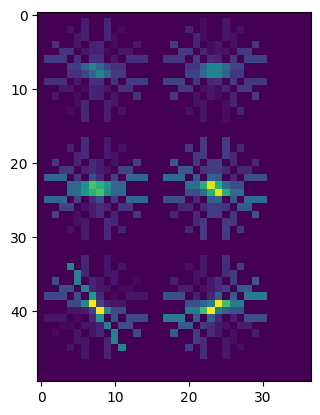

In [26]:
plt.imshow(image_rescaled["hog_image_1"][1])

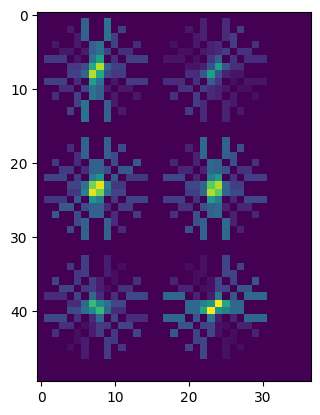

In [27]:
plt.imshow(image_rescaled["hog_image_2"][1])

### 3. Preparing the local_binary_patterns data

In [28]:
def ldp_data(data):
    flattend_arr = []
    lbp_image = []
    for image in data:
        arr_2d = local_binary_patterns(image)
        lbp_image.append(arr_2d)
        flattend_arr.append(arr_2d.flatten())
        
    return np.array(flattend_arr), np.array(lbp_image)

image_rescaled["lbp_data_1"], image_rescaled["lbp_image_1"] = ldp_data(cnn_train_data_1)
image_rescaled["lbp_data_2"], image_rescaled["lbp_image_2"] = ldp_data(cnn_train_data_2)
image_rescaled["lbp_data_test_1"], image_rescaled["lbp_image_test_1"] = ldp_data(cnn_test_data_1)
image_rescaled["lbp_data_test_2"], image_rescaled["lbp_image_test_2"] = ldp_data(cnn_test_data_2)

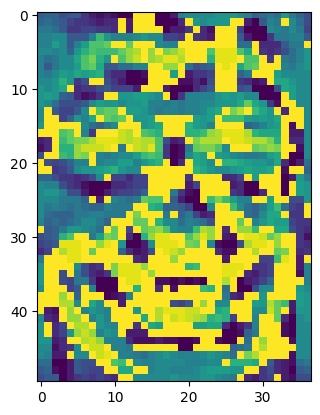

In [29]:
plt.imshow(image_rescaled["lbp_image_1"][1])

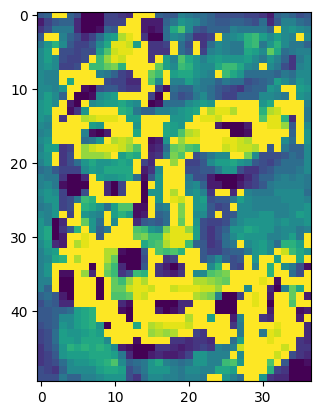

In [30]:
plt.imshow(image_rescaled["lbp_image_2"][1])

### 4. Implementing pca on lbp/sift/hog

In [31]:
image_rescaled.keys()

dict_keys(['sift_data_1', 'sift_image_1', 'sift_data_2', 'sift_image_2', 'sift_data_test_1', 'sift_image_test_1', 'sift_data_test_2', 'sift_image_test_2', 'hog_data_1', 'hog_image_1', 'hog_data_2', 'hog_image_2', 'hog_data_test_1', 'hog_image_test_1', 'hog_data_test_2', 'hog_image_test_2', 'lbp_data_1', 'lbp_image_1', 'lbp_data_2', 'lbp_image_2', 'lbp_data_test_1', 'lbp_image_test_1', 'lbp_data_test_2', 'lbp_image_test_2'])

In [32]:
image_rescaled['lbp_image_test_1'][0].shape, image_rescaled['lbp_image_1'][0].shape

((50, 37), (50, 37))

In [33]:
image_rescaled['lbp_image_test_2'][0].shape, image_rescaled['lbp_image_2'][0].shape

((50, 37), (50, 37))

In [34]:
def pca_implementation(X_train, X_test):
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = 150

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, 50, 37))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca

#### 4.1 LBP PCA Data

In [35]:
X_train_pca_lbp_1, X_test_pca_lbp_1 = pca_implementation(image_rescaled['lbp_data_1'], image_rescaled['lbp_data_test_1'])
X_train_pca_lbp_2, X_test_pca_lbp_2 = pca_implementation(image_rescaled['lbp_data_2'], image_rescaled['lbp_data_test_2'])

X_train_pca_lbp = np.hstack((X_train_pca_lbp_1,X_train_pca_lbp_2))
X_test_pca_lbp = np.hstack((X_test_pca_lbp_1,X_test_pca_lbp_2))

print(f"shape of train:: {X_train_pca_lbp.shape} and test:: {X_test_pca_lbp.shape} on lbp ")

Extracting the top 150 eigenfaces from 2200 faces
done in 2.118s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.105s
Extracting the top 150 eigenfaces from 2200 faces
done in 1.708s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.092s
shape of train:: (2200, 300) and test:: (1000, 300) on lbp 


In [38]:
X_train_pca_lbp_1.shape, X_train_pca_lbp_2.shape, X_test_pca_lbp_1.shape, X_test_pca_lbp_2.shape

((2200, 150), (2200, 150), (1000, 150), (1000, 150))

#### 4.2 HOG PCA DATA

In [58]:
image_rescaled.keys()

dict_keys(['sift_data_1', 'sift_image_1', 'sift_data_2', 'sift_image_2', 'hog_data_1', 'hog_image_1', 'hog_data_2', 'hog_image_2', 'lbp_data_1', 'lbp_image_1', 'lbp_data_2', 'lbp_image_2', 'sift_data_test_1', 'sift_image_test_1', 'sift_data_test_2', 'sift_image_test_2', 'hog_data_test_1', 'hog_image_test_1', 'hog_data_test_2', 'hog_image_test_2', 'lbp_data_test_1', 'lbp_image_test_1', 'lbp_data_test_2', 'lbp_image_test_2'])

In [59]:
X_train_pca_hog_1, X_test_pca_hog_1 = pca_implementation(image_rescaled['hog_data_1'], image_rescaled['hog_data_test_1'])
X_train_pca_hog_2, X_test_pca_hog_2 = pca_implementation(image_rescaled['hog_data_2'], image_rescaled['hog_data_test_2'])

X_train_pca_hog = np.hstack((X_train_pca_hog_1,X_train_pca_hog_2))
X_test_pca_hog = np.hstack((X_test_pca_hog_1,X_test_pca_hog_2))

print(f"shape of train:: {X_train_pca_hog.shape} and test:: {X_test_pca_hog.shape} on lbp ")

Extracting the top 150 eigenfaces from 2200 faces
done in 0.830s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.035s
Extracting the top 150 eigenfaces from 2200 faces
done in 0.640s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.038s
shape of train:: (2200, 300) and test:: (1000, 300) on lbp 


#### 4.3 SIFT PCA DATA

In [73]:
def pca_implementation_3d(X_train, X_test):
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = 150

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, 50, 37, 3))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca

In [74]:
X_train_pca_sift_1, X_test_pca_sift_1 = pca_implementation_3d(image_rescaled['sift_data_1'], image_rescaled['sift_data_test_1'])
X_train_pca_sift_2, X_test_pca_sift_2 = pca_implementation_3d(image_rescaled['sift_data_2'], image_rescaled['sift_data_test_2'])

X_train_pca_sift = np.hstack((X_train_pca_sift_1,X_train_pca_sift_2))
X_test_pca_sift = np.hstack((X_test_pca_sift_1,X_test_pca_sift_2))

print(f"shape of train:: {X_train_pca_sift.shape} and test:: {X_test_pca_sift.shape} on lbp ")

Extracting the top 150 eigenfaces from 2200 faces
done in 3.332s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.366s
Extracting the top 150 eigenfaces from 2200 faces
done in 3.162s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.259s
shape of train:: (2200, 300) and test:: (1000, 300) on lbp 


### 5. XGBOOST

#### 5.1 Using SIFT PCA and LBP PCA data 

In [76]:
X_train = np.hstack((X_train_pca_sift, X_train_pca_lbp))
X_test = np.hstack((X_test_pca_sift, X_test_pca_lbp))

In [77]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [80]:

xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_pred = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.497

In [81]:


target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(y_pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.39      0.50      0.43       389
      Same person       0.61      0.50      0.55       611

         accuracy                           0.50      1000
        macro avg       0.50      0.50      0.49      1000
     weighted avg       0.52      0.50      0.50      1000



#### 5.2 Using HOG PCA and LBP PCA data

In [82]:
X_train = np.hstack((X_train_pca_hog, X_train_pca_lbp))
X_test = np.hstack((X_test_pca_hog, X_test_pca_lbp))

xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_pred = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.497

In [83]:
target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(y_pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.40      0.53      0.46       376
      Same person       0.65      0.52      0.58       624

         accuracy                           0.53      1000
        macro avg       0.53      0.53      0.52      1000
     weighted avg       0.56      0.53      0.53      1000



### 5.3 Using HOG PCA and SIFT PCA data

In [84]:
X_train = np.hstack((X_train_pca_hog, X_train_pca_sift))
X_test = np.hstack((X_test_pca_hog, X_test_pca_sift))

xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_pred = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.497

In [85]:
target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(y_pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.48      0.51      0.50       469
      Same person       0.54      0.51      0.53       531

         accuracy                           0.51      1000
        macro avg       0.51      0.51      0.51      1000
     weighted avg       0.51      0.51      0.51      1000

